### Chain and multioutput regression models for predicting V, A and D consecutively (normalized variables)

In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler

data_01=pd.read_csv('Emo_Bank_VAD.csv')

print(data_01.columns)
print('')
print(data_01.shape)
print(data_01.head())
print('')
print(data_01.dtypes)

Index(['id', 'split', 'V', 'A', 'D', 'text'], dtype='object')

(9906, 6)
                    id  split     V     A     D  \
0  110CYL068_1036_1079  train  3.00  3.00  3.20   
1  110CYL068_1079_1110   test  2.80  3.10  2.80   
2  110CYL068_1127_1130  train  3.00  3.00  3.00   
3  110CYL068_1137_1188  train  3.44  3.00  3.22   
4  110CYL068_1189_1328  train  3.55  3.27  3.46   

                                                text  
0        Remember what she said in my last letter? "  
1                          If I wasn't working here.  
2                                                .."  
3  Goodwill helps people get off of public assist...  
4  Sherry learned through our Future Works class ...  

id        object
split     object
V        float64
A        float64
D        float64
text      object
dtype: object


In [26]:
# Normalize columns 'A', 'V', and 'D'
scaler = MinMaxScaler(feature_range=(-1, 1))

# Apply the scaler to the columns of interest
data_01[['V', 'A', 'D']] = scaler.fit_transform(data_01[['V', 'A', 'D']])


print(data_01.head())

                    id  split         V         A         D  \
0  110CYL068_1036_1079  train  0.058824 -0.076923  0.173554   
1  110CYL068_1079_1110   test -0.058824  0.000000 -0.157025   
2  110CYL068_1127_1130  train  0.058824 -0.076923  0.008264   
3  110CYL068_1137_1188  train  0.317647 -0.076923  0.190083   
4  110CYL068_1189_1328  train  0.382353  0.130769  0.388430   

                                                text  
0        Remember what she said in my last letter? "  
1                          If I wasn't working here.  
2                                                .."  
3  Goodwill helps people get off of public assist...  
4  Sherry learned through our Future Works class ...  


In [27]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(data_01["text"], data_01[["V", "A", "D"]], test_size=0.1, shuffle=True, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=1)
print("Data shapes:", x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape)

# Define the RegressorChain with Ridge as the base estimator
base_estimator = Ridge()
regressor_chain = RegressorChain(base_estimator=base_estimator, order=[0,1,2])

#Vectorize "text" data
tfidf = TfidfVectorizer()
x_train_tfidf = tfidf.fit_transform(x_train)
x_val_tfidf = tfidf.transform(x_val)
x_test_tfidf = tfidf.transform(x_test)

# Define parameter grid for GridSearchCV
param_grid = {
    'base_estimator__alpha': [0.1, 1.0, 10.0],
    'order': [[0, 1, 2]]  
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=regressor_chain, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(x_train_tfidf, y_train)

# Get the best model from GridSearchCV
best_regressor_chain = grid_search.best_estimator_

# Predict on training, validation, and test datasets
y_train_pred = best_regressor_chain.predict(x_train_tfidf)
y_val_pred = best_regressor_chain.predict(x_val_tfidf)
y_test_pred = best_regressor_chain.predict(x_test_tfidf)

# Convert targets and predictions to numpy arrays 
y_train_np = y_train.to_numpy()
y_val_np = y_val.to_numpy()
y_test_np = y_test.to_numpy()

y_train_pred_np = np.array(y_train_pred)
y_val_pred_np = np.array(y_val_pred)
y_test_pred_np = np.array(y_test_pred)

# Define RMSE function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Evaluate the model performance using RMSE, MSE, and MAE
def evaluate_performance(y_true, y_pred):
    metrics = {}
    metrics['RMSE_V'] = rmse(y_true[:, 0], y_pred[:, 0])
    metrics['RMSE_A'] = rmse(y_true[:, 1], y_pred[:, 1])
    metrics['RMSE_D'] = rmse(y_true[:, 2], y_pred[:, 2])
    
    metrics['MAE_V'] = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    metrics['MAE_A'] = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    metrics['MAE_D'] = mean_absolute_error(y_true[:, 2], y_pred[:, 2])
    
    metrics['MSE_V'] = mean_squared_error(y_true[:, 0], y_pred[:, 0])
    metrics['MSE_A'] = mean_squared_error(y_true[:, 1], y_pred[:, 1])
    metrics['MSE_D'] = mean_squared_error(y_true[:, 2], y_pred[:, 2])
    
    return metrics

# Calculate performance metrics for train, validation, and test datasets
train_metrics = evaluate_performance(y_train_np, y_train_pred_np)
val_metrics = evaluate_performance(y_val_np, y_val_pred_np)
test_metrics = evaluate_performance(y_test_np, y_test_pred_np)


print(f'Best parameters: {grid_search.best_params_}\n')

print("Train Dataset:")
print(f'RMSE for V: {round(train_metrics["RMSE_V"], 2)}')
print(f'RMSE for A: {round(train_metrics["RMSE_A"], 2)}')
print(f'RMSE for D: {round(train_metrics["RMSE_D"], 2)}\n')
print(f'MAE for V: {round(train_metrics["MAE_V"], 2)}')
print(f'MAE for A: {round(train_metrics["MAE_A"], 2)}')
print(f'MAE for D: {round(train_metrics["MAE_D"], 2)}\n')
print(f'MSE for V: {round(train_metrics["MSE_V"], 2)}')
print(f'MSE for A: {round(train_metrics["MSE_A"], 2)}')
print(f'MSE for D: {round(train_metrics["MSE_D"], 2)}\n')

print("Validation Dataset:")
print(f'RMSE for V: {round(val_metrics["RMSE_V"], 2)}')
print(f'RMSE for A: {round(val_metrics["RMSE_A"], 2)}')
print(f'RMSE for D: {round(val_metrics["RMSE_D"], 2)}\n')
print(f'MAE for V: {round(val_metrics["MAE_V"], 2)}')
print(f'MAE for A: {round(val_metrics["MAE_A"], 2)}')
print(f'MAE for D: {round(val_metrics["MAE_D"], 2)}\n')
print(f'MSE for V: {round(val_metrics["MSE_V"], 2)}')
print(f'MSE for A: {round(val_metrics["MSE_A"], 2)}')
print(f'MSE for D: {round(val_metrics["MSE_D"], 2)}\n')

print("Test Dataset:")
print(f'RMSE for V: {round(test_metrics["RMSE_V"], 2)}')
print(f'RMSE for A: {round(test_metrics["RMSE_A"], 2)}')
print(f'RMSE for D: {round(test_metrics["RMSE_D"], 2)}\n')
print(f'MAE for V: {round(test_metrics["MAE_V"], 2)}')
print(f'MAE for A: {round(test_metrics["MAE_A"], 2)}')
print(f'MAE for D: {round(test_metrics["MAE_D"], 2)}\n')
print(f'MSE for V: {round(test_metrics["MSE_V"], 2)}')
print(f'MSE for A: {round(test_metrics["MSE_A"], 2)}')
print(f'MSE for D: {round(test_metrics["MSE_D"], 2)}\n')



Data shapes: (8023,) (892,) (991,) (8023, 3) (892, 3) (991, 3)
Best parameters: {'base_estimator__alpha': 1.0, 'order': [0, 1, 2]}

Train Dataset:
RMSE for V: 0.11
RMSE for A: 0.13
RMSE for D: 0.11

MAE for V: 0.08
MAE for A: 0.1
MAE for D: 0.08

MSE for V: 0.01
MSE for A: 0.02
MSE for D: 0.01

Validation Dataset:
RMSE for V: 0.17
RMSE for A: 0.19
RMSE for D: 0.18

MAE for V: 0.13
MAE for A: 0.14
MAE for D: 0.14

MSE for V: 0.03
MSE for A: 0.04
MSE for D: 0.03

Test Dataset:
RMSE for V: 0.17
RMSE for A: 0.2
RMSE for D: 0.18

MAE for V: 0.13
MAE for A: 0.15
MAE for D: 0.13

MSE for V: 0.03
MSE for A: 0.04
MSE for D: 0.03



In [18]:
# Create tables to compare predicted and real values

# Convert predictions to DataFrames and round to two decimals
y_train_pred_df = pd.DataFrame(y_train_pred, columns=["V_pred", "A_pred", "D_pred"])
y_val_pred_df = pd.DataFrame(y_val_pred, columns=["V_pred", "A_pred", "D_pred"])
y_test_pred_df = pd.DataFrame(y_test_pred, columns=["V_pred", "A_pred", "D_pred"])

# Concatenate real and predicted values
train_comparison = pd.concat([y_train.reset_index(drop=True), y_train_pred_df], axis=1)
val_comparison = pd.concat([y_val.reset_index(drop=True), y_val_pred_df], axis=1)
test_comparison = pd.concat([y_test.reset_index(drop=True), y_test_pred_df], axis=1)

# Print comparison tables
print("Training Data Comparison:\n", train_comparison.head())
print("\nValidation Data Comparison:\n", val_comparison.head())
print("\nTest Data Comparison:\n", test_comparison.head())

# Save the comparison tables to CSV files
train_comparison.to_csv("train_comparison_chain_norm.csv", index=False)
val_comparison.to_csv("val_comparison_chain_norm.csv", index=False)
test_comparison.to_csv("test_comparison_chain_norm.csv", index=False)

Training Data Comparison:
           V         A         D    V_pred    A_pred    D_pred
0  0.058824 -0.307692  0.090909  0.069200 -0.142937  0.095083
1 -0.235294  0.000000 -0.157025 -0.120247 -0.039098 -0.036351
2 -0.352941  0.000000 -0.157025 -0.160156  0.059044 -0.094632
3  0.388235  0.176923  0.099174  0.309565  0.088176  0.080994
4  0.058824 -0.076923  0.008264  0.052696 -0.068268  0.033057

Validation Data Comparison:
               V         A         D    V_pred    A_pred    D_pred
0  1.176471e-01  0.000000  0.669421  0.168649  0.100878  0.012728
1  2.220446e-16 -0.153846 -0.074380  0.090231 -0.053512  0.050979
2  5.882353e-02  0.253846  0.363636 -0.254063 -0.056928 -0.008773
3  1.235294e-01 -0.076923  0.190083 -0.007789 -0.112688 -0.047463
4  5.882353e-02  0.076923  0.090909  0.030918 -0.069116  0.021446

Test Data Comparison:
               V         A         D    V_pred    A_pred    D_pred
0  2.220446e-16 -0.692308 -0.074380  0.080095 -0.007321  0.000054
1 -1.764706e-01  0.

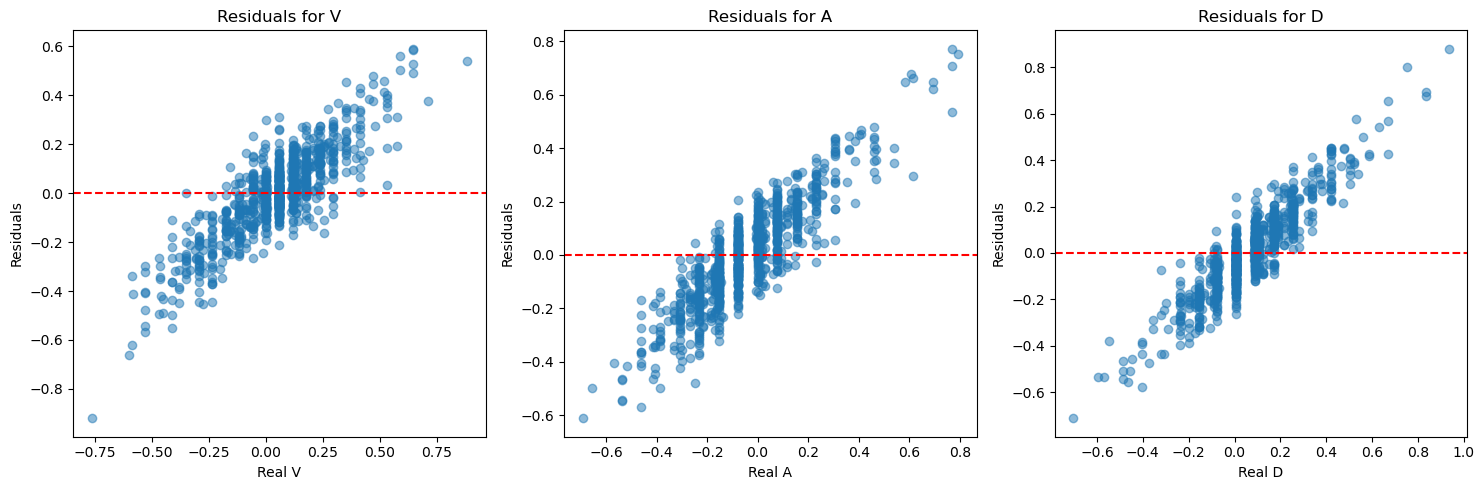

In [19]:
# Calculate residuals
residuals_v = y_val_np[:, 0] - y_val_pred_np[:, 0]
residuals_a = y_val_np[:, 1] - y_val_pred_np[:, 1]
residuals_d = y_val_np[:, 2] - y_val_pred_np[:, 2]

# Visualize the residuals
plt.figure(figsize=(15, 5))

# Residuals for V
plt.subplot(1, 3, 1)
plt.scatter(y_val_np[:, 0], residuals_v, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Real V')
plt.ylabel('Residuals')
plt.title('Residuals for V')

# Residuals for A
plt.subplot(1, 3, 2)
plt.scatter(y_val_np[:, 1], residuals_a, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Real A')
plt.ylabel('Residuals')
plt.title('Residuals for A')

# Residuals for D
plt.subplot(1, 3, 3)
plt.scatter(y_val_np[:, 2], residuals_d, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Real D')
plt.ylabel('Residuals')
plt.title('Residuals for D')

plt.tight_layout()
plt.show()



#### Multioutput regression

In [20]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(data_01["text"], data_01[["V", "A", "D"]], test_size=0.1, shuffle=True, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=1)
print("Data shapes:", x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape)

#Vectorize "text" data
tfidf = TfidfVectorizer()
x_train_tfidf = tfidf.fit_transform(x_train)
x_val_tfidf = tfidf.transform(x_val)
x_test_tfidf = tfidf.transform(x_test)

# Initialize the Ridge regressor
ridge = Ridge()

# Define a parameter grid for Ridge regression
param_grid = {
    'estimator__alpha': [0.1, 1, 10, 100] 
}

# Set up the MultiOutputRegressor with GridSearchCV
multi_output_ridge = MultiOutputRegressor(ridge)
grid_search = GridSearchCV(multi_output_ridge, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model with hyperparameter tuning
grid_search.fit(x_train_tfidf, y_train)

# Best parameters from GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Predict on train, validation, and test datasets
y_train_pred = grid_search.predict(x_train_tfidf)
y_val_pred = grid_search.predict(x_val_tfidf)
y_test_pred = grid_search.predict(x_test_tfidf)

# Convert targets and predictions to numpy arrays for consistency
y_train_np = y_train.to_numpy()
y_val_np = y_val.to_numpy()
y_test_np = y_test.to_numpy()
y_train_pred_np = np.array(y_train_pred)
y_val_pred_np = np.array(y_val_pred)
y_test_pred_np = np.array(y_test_pred)
# Evaluate the model performance using RMSE, MSE, and MAE
def evaluate_performance(y_true, y_pred):
    metrics = {}
    metrics['RMSE_V'] = rmse(y_true[:, 0], y_pred[:, 0])
    metrics['RMSE_A'] = rmse(y_true[:, 1], y_pred[:, 1])
    metrics['RMSE_D'] = rmse(y_true[:, 2], y_pred[:, 2])
    
    metrics['MAE_V'] = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    metrics['MAE_A'] = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    metrics['MAE_D'] = mean_absolute_error(y_true[:, 2], y_pred[:, 2])
    
    metrics['MSE_V'] = mean_squared_error(y_true[:, 0], y_pred[:, 0])
    metrics['MSE_A'] = mean_squared_error(y_true[:, 1], y_pred[:, 1])
    metrics['MSE_D'] = mean_squared_error(y_true[:, 2], y_pred[:, 2])
    
    return metrics

# Calculate performance metrics for train, validation, and test datasets
train_metrics = evaluate_performance(y_train_np, y_train_pred_np)
val_metrics = evaluate_performance(y_val_np, y_val_pred_np)
test_metrics = evaluate_performance(y_test_np, y_test_pred_np)


print(f'Best parameters: {grid_search.best_params_}\n')

print("Train Dataset:")
print(f'RMSE for V: {round(train_metrics["RMSE_V"], 2)}')
print(f'RMSE for A: {round(train_metrics["RMSE_A"], 2)}')
print(f'RMSE for D: {round(train_metrics["RMSE_D"], 2)}\n')
print(f'MAE for V: {round(train_metrics["MAE_V"], 2)}')
print(f'MAE for A: {round(train_metrics["MAE_A"], 2)}')
print(f'MAE for D: {round(train_metrics["MAE_D"], 2)}\n')
print(f'MSE for V: {round(train_metrics["MSE_V"], 2)}')
print(f'MSE for A: {round(train_metrics["MSE_A"], 2)}')
print(f'MSE for D: {round(train_metrics["MSE_D"], 2)}\n')

print("Validation Dataset:")
print(f'RMSE for V: {round(val_metrics["RMSE_V"], 2)}')
print(f'RMSE for A: {round(val_metrics["RMSE_A"], 2)}')
print(f'RMSE for D: {round(val_metrics["RMSE_D"], 2)}\n')
print(f'MAE for V: {round(val_metrics["MAE_V"], 2)}')
print(f'MAE for A: {round(val_metrics["MAE_A"], 2)}')
print(f'MAE for D: {round(val_metrics["MAE_D"], 2)}\n')
print(f'MSE for V: {round(val_metrics["MSE_V"], 2)}')
print(f'MSE for A: {round(val_metrics["MSE_A"], 2)}')
print(f'MSE for D: {round(val_metrics["MSE_D"], 2)}\n')

print("Test Dataset:")
print(f'RMSE for V: {round(test_metrics["RMSE_V"], 2)}')
print(f'RMSE for A: {round(test_metrics["RMSE_A"], 2)}')
print(f'RMSE for D: {round(test_metrics["RMSE_D"], 2)}\n')
print(f'MAE for V: {round(test_metrics["MAE_V"], 2)}')
print(f'MAE for A: {round(test_metrics["MAE_A"], 2)}')
print(f'MAE for D: {round(test_metrics["MAE_D"], 2)}\n')
print(f'MSE for V: {round(test_metrics["MSE_V"], 2)}')
print(f'MSE for A: {round(test_metrics["MSE_A"], 2)}')
print(f'MSE for D: {round(test_metrics["MSE_D"], 2)}\n')



Data shapes: (8023,) (892,) (991,) (8023, 3) (892, 3) (991, 3)
Best parameters found:  {'estimator__alpha': 1}
Best parameters: {'estimator__alpha': 1}

Train Dataset:
RMSE for V: 0.11
RMSE for A: 0.13
RMSE for D: 0.11

MAE for V: 0.08
MAE for A: 0.1
MAE for D: 0.08

MSE for V: 0.01
MSE for A: 0.02
MSE for D: 0.01

Validation Dataset:
RMSE for V: 0.17
RMSE for A: 0.19
RMSE for D: 0.18

MAE for V: 0.13
MAE for A: 0.14
MAE for D: 0.14

MSE for V: 0.03
MSE for A: 0.04
MSE for D: 0.03

Test Dataset:
RMSE for V: 0.17
RMSE for A: 0.2
RMSE for D: 0.18

MAE for V: 0.13
MAE for A: 0.15
MAE for D: 0.13

MSE for V: 0.03
MSE for A: 0.04
MSE for D: 0.03



In [22]:
# Create tables to compare predicted and real values

# Convert predictions to DataFrames and round to two decimals
y_train_pred_df = pd.DataFrame(y_train_pred, columns=["V_pred", "A_pred", "D_pred"])
y_val_pred_df = pd.DataFrame(y_val_pred, columns=["V_pred", "A_pred", "D_pred"])
y_test_pred_df = pd.DataFrame(y_test_pred, columns=["V_pred", "A_pred", "D_pred"])

# Concatenate real and predicted values
train_comparison = pd.concat([y_train.reset_index(drop=True), y_train_pred_df], axis=1)
val_comparison = pd.concat([y_val.reset_index(drop=True), y_val_pred_df], axis=1)
test_comparison = pd.concat([y_test.reset_index(drop=True), y_test_pred_df], axis=1)

# Print comparison tables
print("Training Data Comparison:\n", train_comparison.head())
print("\nValidation Data Comparison:\n", val_comparison.head())
print("\nTest Data Comparison:\n", test_comparison.head())

# Save the comparison tables to CSV files
train_comparison.to_csv("train_comparison_mo_norm.csv", index=False)
val_comparison.to_csv("val_comparison_mo_norm.csv", index=False)
test_comparison.to_csv("test_comparison_mo_norm.csv", index=False) 

Training Data Comparison:
           V         A         D    V_pred    A_pred    D_pred
0  0.058824 -0.307692  0.090909  0.069200 -0.142935  0.095093
1 -0.235294  0.000000 -0.157025 -0.120247 -0.039089 -0.036357
2 -0.352941  0.000000 -0.157025 -0.160156  0.059059 -0.094644
3  0.388235  0.176923  0.099174  0.309565  0.088167  0.080995
4  0.058824 -0.076923  0.008264  0.052696 -0.068267  0.033061

Validation Data Comparison:
               V         A         D    V_pred    A_pred    D_pred
0  1.176471e-01  0.000000  0.669421  0.168649  0.100878  0.012732
1  2.220446e-16 -0.153846 -0.074380  0.090231 -0.053516  0.050979
2  5.882353e-02  0.253846  0.363636 -0.254063 -0.056919 -0.008768
3  1.235294e-01 -0.076923  0.190083 -0.007789 -0.112683 -0.047435
4  5.882353e-02  0.076923  0.090909  0.030918 -0.069118  0.021460

Test Data Comparison:
               V         A         D    V_pred    A_pred    D_pred
0  2.220446e-16 -0.692308 -0.074380  0.080095 -0.007320  0.000059
1 -1.764706e-01  0.

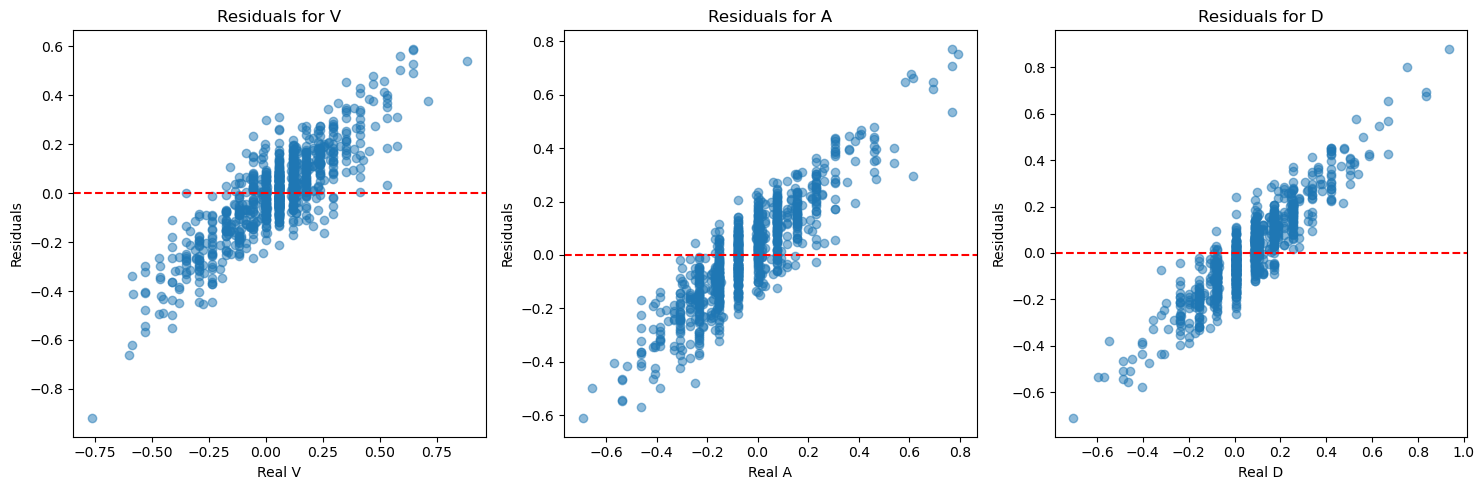

In [24]:
# Calculate residuals
residuals_v = y_val_np[:, 0] - y_val_pred_np[:, 0]
residuals_a = y_val_np[:, 1] - y_val_pred_np[:, 1]
residuals_d = y_val_np[:, 2] - y_val_pred_np[:, 2]

# Visualize the residuals
plt.figure(figsize=(15, 5))

# Residuals for V
plt.subplot(1, 3, 1)
plt.scatter(y_val_np[:, 0], residuals_v, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Real V')
plt.ylabel('Residuals')
plt.title('Residuals for V')

# Residuals for A
plt.subplot(1, 3, 2)
plt.scatter(y_val_np[:, 1], residuals_a, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Real A')
plt.ylabel('Residuals')
plt.title('Residuals for A')

# Residuals for D
plt.subplot(1, 3, 3)
plt.scatter(y_val_np[:, 2], residuals_d, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Real D')
plt.ylabel('Residuals')
plt.title('Residuals for D')

plt.tight_layout()
plt.show()

